# Import Libraries

In [805]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.data import Data
import scipy.sparse as sp
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import scipy
import json
from random import shuffle

from matplotlib import pyplot as plt

# Import Data

In [806]:
adj = sp.load_npz('./data_2023/adj.npz')
feat  = np.load('./data_2023/features.npy')
labels = np.load('./data_2023/labels.npy')
splits = json.load(open('./data_2023/splits.json'))
idx_train, idx_test = splits['idx_train'], splits['idx_test']

### Label counts for trianing set

In [807]:
# The features for this data set are 0-1 features
edge_index = from_scipy_sparse_matrix(adj)
print("Label counts:")
for i in range(7):
    print("{}) ".format(i), list(labels).count(i), round(list(labels).count(i) / labels.shape[0] * 100, 2), "%")

Label counts:
0)  57 11.49 %
1)  81 16.33 %
2)  145 29.23 %
3)  76 15.32 %
4)  43 8.67 %
5)  26 5.24 %
6)  68 13.71 %


### Identifying Data Splits

In [808]:
train_split = splits["idx_train"]
test_split = splits["idx_test"]

validation_split = train_split[:99]
train_split = train_split[99:]

mask_temp = np.array([])
for i in range(feat.shape[0]):
    if i in train_split:
        mask_temp = np.append(mask_temp, 0)
    elif i in test_split:
        mask_temp = np.append(mask_temp, 1)
    else:
        mask_temp = np.append(mask_temp, 2)
train_mask = (mask_temp == 0)
test_mask = (mask_temp == 1)
validation_mask = (mask_temp == 2)

# Maybe need to change below to long
x = torch.tensor(feat, dtype=torch.float)

label_mask = []
ind = 0
for i in range(x.shape[0]):
    if i in train_split or i in validation_split:
        label_mask.append(labels[idx_train.index(i)])
        ind += 1
    else:
        label_mask.append(-1)
label_mask = torch.tensor(label_mask, dtype=torch.long)
print(label_mask.shape)
# train_mask = torch.tensor(train_mask, dtype=torch.bool)
# test_mask = torch.tensor(test_mask, dtype=torch.bool)
# validation_mask = torch.tensor(validation_mask, dtype=torch.bool)
data = Data(x=x, edge_index=edge_index[0], y=label_mask, train_mask=train_mask, test_mask=test_mask, val_mask=validation_mask)
data

torch.Size([2480])


Data(x=[2480, 1390], edge_index=[2, 10100], y=[2480], train_mask=[2480], test_mask=[2480], val_mask=[2480])

In [809]:
print(data.train_mask[:50], data.val_mask.sum(), data.test_mask[:50])

[False False False  True False False False False False False False False
  True  True False False False False  True False False False False False
 False False False False  True False  True False False False False False
  True False False False False False False False False False False False
 False False] 99 [ True  True  True False  True  True  True  True  True  True  True  True
 False False  True  True  True  True False  True  True  True  True  True
  True  True  True  True False  True False  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True]


In [810]:
label_mask[:50]

tensor([-1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  6,  6, -1, -1, -1, -1,
         0, -1, -1, -1, -1, -1, -1, -1, -1, -1,  2, -1,  4, -1, -1, -1, -1, -1,
         3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

# Construct Classifier

In [811]:
class GCNSimple(torch.nn.Module):
    def __init__(self, num_node_features, num_hidden1, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, num_hidden1)
        self.conv2 = GCNConv(num_hidden1, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

# Training

In [812]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
model = GCNSimple(num_node_features=data.x.shape[1], 
            num_hidden1=16,
            num_classes=(data.y.max()+1).item()
            ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

accuracies = []
accuracies2 = []
model.train()
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print('Epoch {0}: {1}'.format(epoch, loss.item()))
    
    model.eval()
    with torch.no_grad():
        predictions = model(data).argmax(dim=1)
        correct = (predictions[data.val_mask] == data.y[data.val_mask]).sum()
        acc = int(correct) / int(data.val_mask.sum())
        accuracies.append(acc)

        predictions = model(data).argmax(dim=1)
        correct = (predictions[data.train_mask] == data.y[data.train_mask]).sum()
        acc = int(correct) / int(data.train_mask.sum())
        accuracies2.append(acc)

Epoch 0: 1.9486016035079956
Epoch 10: 0.8389590382575989
Epoch 20: 0.26699838042259216
Epoch 30: 0.1002979725599289
Epoch 40: 0.05385524407029152
Epoch 50: 0.03960828855633736
Epoch 60: 0.03611096367239952
Epoch 70: 0.03528466075658798
Epoch 80: 0.03429506719112396
Epoch 90: 0.032545268535614014


## Plot Accuracies

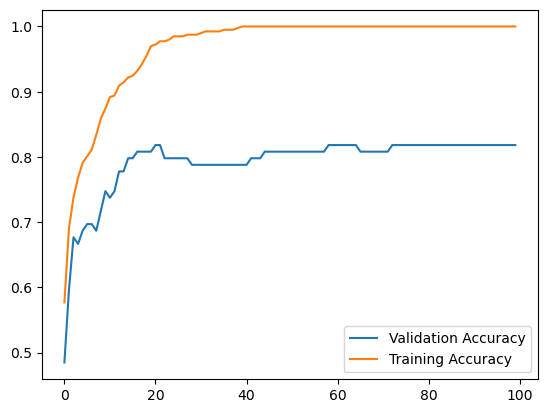

In [813]:
plt.plot(np.arange(0,epochs,1), accuracies, label="Validation Accuracy")
plt.plot(np.arange(0,epochs,1), accuracies2, label="Training Accuracy")
plt.legend()

# Testing (Against Validation)

In [828]:
model.eval()
predictions = model(data).argmax(dim=1)
correct = (predictions[data.val_mask] == data.y[data.val_mask]).sum()
acc = int(correct) / int(data.val_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8182


# Testing (Training Accuracy)

In [829]:
model.eval()
predictions = model(data).argmax(dim=1)
correct = (predictions[data.train_mask] == data.y[data.train_mask]).sum()
acc = int(correct) / int(data.train_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 1.0000


### Testing Label Counts

In [816]:
print("Label counts:")
for i in range(7):
    print("{}) ".format(i), list(predictions).count(i), round(list(predictions).count(i) / predictions.shape[0] * 100, 2), "%")

Label counts:
0)  287 11.57 %
1)  419 16.9 %
2)  718 28.95 %
3)  339 13.67 %
4)  195 7.86 %
5)  132 5.32 %
6)  390 15.73 %


In [826]:
predictions[idx_train][:99]

tensor([2, 3, 6, 2, 3, 4, 5, 0, 6, 1, 2, 1, 5, 2, 3, 2, 2, 5, 0, 3, 6, 6, 0, 5,
        0, 3, 2, 0, 3, 1, 2, 3, 1, 2, 2, 2, 3, 2, 3, 1, 1, 5, 2, 1, 4, 1, 2, 2,
        2, 6, 6, 1, 1, 4, 1, 3, 3, 3, 0, 6, 3, 2, 5, 2, 2, 2, 1, 3, 1, 4, 4, 2,
        1, 1, 1, 0, 2, 2, 2, 2, 2, 6, 3, 1, 2, 0, 1, 2, 1, 4, 6, 5, 0, 5, 1, 0,
        2, 6, 0])

In [824]:
labels[:99]

array([6, 3, 6, 2, 3, 4, 5, 0, 6, 1, 2, 1, 5, 6, 3, 2, 2, 5, 0, 3, 6, 2,
       0, 0, 0, 3, 4, 0, 6, 1, 2, 3, 1, 2, 2, 2, 3, 6, 3, 1, 1, 6, 2, 1,
       4, 1, 2, 2, 2, 6, 6, 2, 1, 4, 1, 3, 3, 3, 0, 5, 3, 2, 0, 2, 2, 2,
       1, 3, 1, 4, 4, 2, 1, 1, 1, 0, 4, 2, 2, 2, 2, 3, 3, 1, 2, 4, 1, 2,
       1, 4, 3, 5, 0, 6, 1, 0, 2, 2, 6], dtype=int8)

# Submit

In [830]:
test_predictions = predictions[idx_test]
print(test_predictions.shape)
np.savetxt("submission.txt", test_predictions, fmt='%d')

torch.Size([1984])


## Misc.

In [203]:
# Evaluate similarity of submissions
with open('submission.txt', 'r') as current, open('submissionv1.txt', 'r') as previous:
    current_predictions = [line.rstrip() for line in current]
    previous_predictions = [line.rstrip() for line in previous]
    similarity = sum([a == b for a, b in zip(current_predictions, previous_predictions)]) / len(current_predictions)
    similarity = round(similarity * 100, 2)
    
print(similarity)

18.09


In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_hidden1, num_hidden2, num_hidden3, num_hidden4, num_hidden5, num_classes, prob=0.5):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, num_hidden1)
        self.conv2 = GCNConv(num_hidden1, num_hidden2)
        self.conv3 = GCNConv(num_hidden2, num_hidden3)
        self.conv4 = GCNConv(num_hidden3, num_hidden4)
        self.conv5 = GCNConv(num_hidden4, num_hidden5)
        self.conv6 = GCNConv(num_hidden5, num_classes)
        self.prob = prob

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, self.prob)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, self.prob)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, self.prob)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, self.prob)
        x = self.conv5(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, self.prob)
        x = self.conv6(x, edge_index)

        return F.log_softmax(x, dim=1)

In [ ]:
class GAT(torch.nn.Module):
    def __init__(self, num_node_features, num_hidden1, num_hidden2, num_hidden3, num_hidden4, num_hidden5, num_classes, prob=0.5):
        super().__init__()
        self.conv1 = GATConv(num_node_features, num_hidden1)
        self.conv2 = GATConv(num_hidden1, num_hidden2)
        self.conv3 = GATConv(num_hidden2, num_hidden3)
        self.conv4 = GATConv(num_hidden3, num_hidden4)
        self.conv5 = GCNConv(num_hidden4, num_hidden5)
        self.conv6 = GCNConv(num_hidden5, num_classes)
        self.prob = prob

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, self.prob)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, self.prob)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, self.prob)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, self.prob)
        x = self.conv5(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, self.prob)
        x = self.conv6(x, edge_index)

        return F.log_softmax(x, dim=1)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
model = GCNSimple(num_node_features=data.x.shape[1], 
            num_hidden1=16,
            num_classes=(data.y.max()+1).item()
            ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# learn_rate = 0.0101

accuracies = []
accuracies2 = []
model.train()
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print('Epoch {0}: {1}'.format(epoch, loss.item()))
    
    model.eval()
    with torch.no_grad():
        predictions = model(data).argmax(dim=1)
        correct = (predictions[data.val_mask] == data.y[data.val_mask]).sum()
        acc = int(correct) / int(data.val_mask.sum())
        accuracies.append(acc)

        predictions = model(data).argmax(dim=1)
        correct = (predictions[data.train_mask] == data.y[data.train_mask]).sum()
        acc = int(correct) / int(data.train_mask.sum())
        accuracies2.append(acc)
    
# runtimes = {}
# for size in range(0, 1000, 50):
#     model = GCNSimple(num_node_features=data.x.shape[1], 
#             num_hidden1=500,
#             num_classes=int((data.y.max()+1).item())
#            ).to(device)
#     for epoch in range(epochs):
#     #     learn_rate -= 0.00005
#     #     optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
#         optimizer.zero_grad()
#         out = model(data)
#         # Negative log likelihood loss
#     #     print(out[data.train_mask], out[data.train_mask].shape)
#     #     print(data.y, data.y.shape)
#         loss = F.nll_loss(out[data.train_mask], data.y[99:].long())
#         loss.backward()
#         optimizer.step()
#         if epoch % 10 == 0:
#             print('Epoch {0}: {1}'.format(epoch, loss.item()))

#         model.eval()
#         predictions = model(data).argmax(dim=1)
#         correct = (predictions[data.val_mask] == data.y[:99]).sum()
#         acc = int(correct) / int(data.val_mask.sum())
#         if size in runtimes:
#             runtimes[size].append(acc)
#         else:
#             runtimes[size] = [acc]
    
#     predictions = model(data).argmax(dim=1)
#     correct = (predictions[data.train_mask] == data.y[99:]).sum()
#     acc = int(correct) / int(data.train_mask.sum())
#     accuracies2.append(acc)